In [1]:
#Source: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb
#https://www.tensorflow.org/tutorials/images/classification?hl=en
import numpy as np
import os
import PIL
import PIL.Image


import sys
from PIL import Image
sys.modules['Image'] = Image 

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

In [2]:
import pathlib

data_dir="../keras/grayscale"
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

119


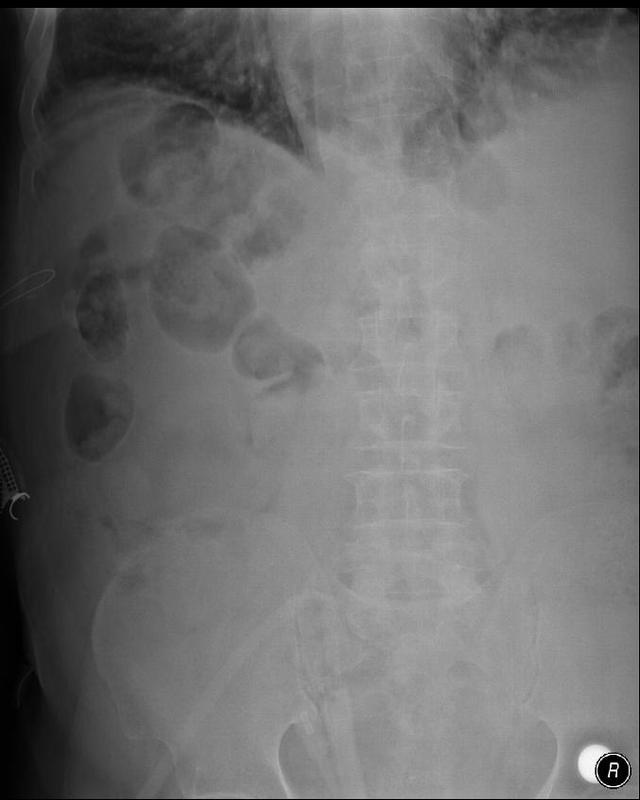

In [4]:
kidneys = list(data_dir.glob('healthy/*'))
PIL.Image.open(str(kidneys[0]))

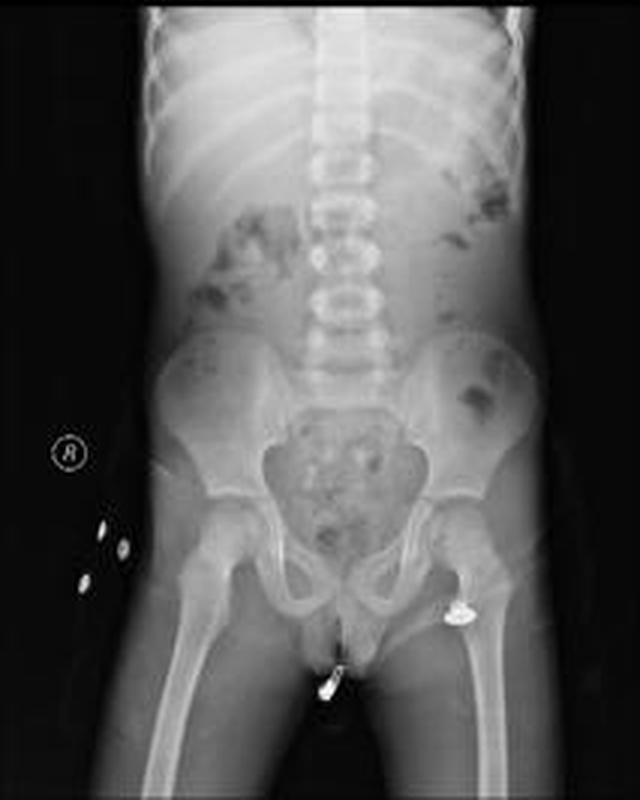

In [5]:
kidneys = list(data_dir.glob('patient/*'))
PIL.Image.open(str(kidneys[1]))

In [6]:
batch_size = 32
img_height = 800
img_width = 640

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 119 files belonging to 2 classes.
Using 96 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 119 files belonging to 2 classes.
Using 23 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'patient']


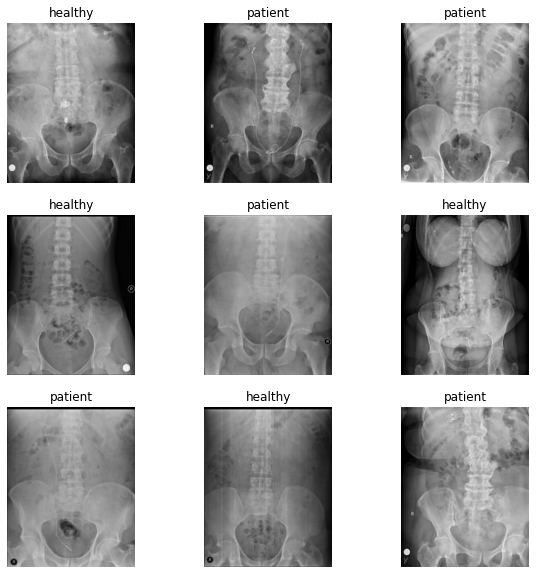

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 800, 640, 3)
(32,)


In [12]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9215687


In [27]:
#train a model
num_classes = 2

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [29]:
epochs=15
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 22s 7s/step - loss: 10.4128 - accuracy: 0.5833 - val_loss: 7.6932 - val_accuracy: 0.1304
Epoch 2/15
3/3 [==============================] - 20s 7s/step - loss: 3.6703 - accuracy: 0.4583 - val_loss: 0.4342 - val_accuracy: 0.8696
Epoch 3/15
3/3 [==============================] - 21s 7s/step - loss: 0.7958 - accuracy: 0.6667 - val_loss: 0.7997 - val_accuracy: 0.1304
Epoch 4/15
3/3 [==============================] - 24s 8s/step - loss: 0.6447 - accuracy: 0.5625 - val_loss: 0.4427 - val_accuracy: 0.8696
Epoch 5/15
3/3 [==============================] - 21s 7s/step - loss: 0.5649 - accuracy: 0.7604 - val_loss: 0.4912 - val_accuracy: 0.8696
Epoch 6/15
3/3 [==============================] - 20s 7s/step - loss: 0.4759 - accuracy: 0.8229 - val_loss: 0.5249 - val_accuracy: 0.9130
Epoch 7/15
3/3 [==============================] - 21s 7s/step - loss: 0.3910 - accuracy: 0.8750 - val_loss: 0.3367 - val_accuracy: 0.9130
Epoch 8/15
3/3 [=================

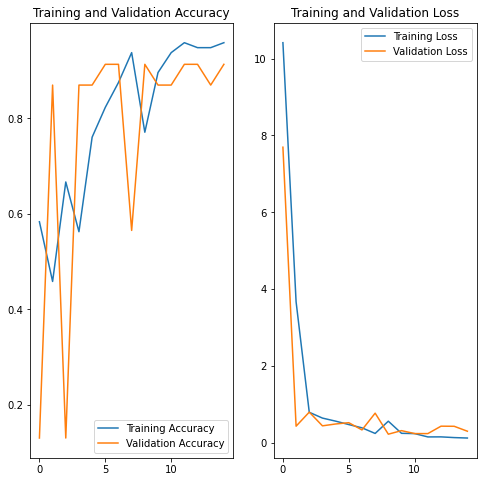

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
#Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

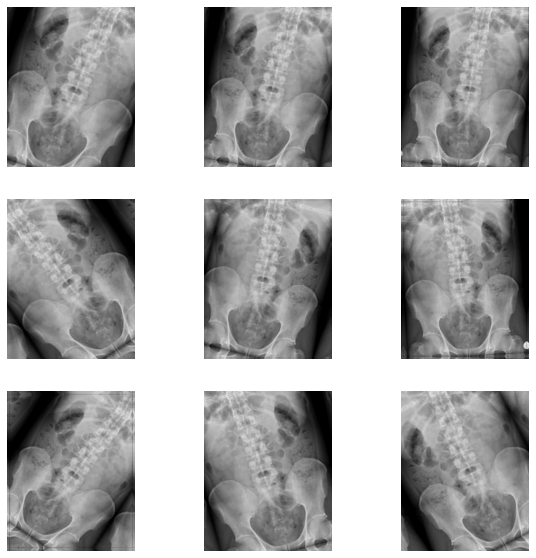

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
#dropout
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 18s 6s/step - loss: 19.2248 - accuracy: 0.5729 - val_loss: 36.1811 - val_accuracy: 0.1304
Epoch 2/15
3/3 [==============================] - 19s 6s/step - loss: 16.7802 - accuracy: 0.3333 - val_loss: 0.4626 - val_accuracy: 0.8696
Epoch 3/15
3/3 [==============================] - 19s 6s/step - loss: 1.1452 - accuracy: 0.6667 - val_loss: 0.7319 - val_accuracy: 0.8696
Epoch 4/15
3/3 [==============================] - 19s 6s/step - loss: 0.7552 - accuracy: 0.6667 - val_loss: 0.4566 - val_accuracy: 0.8696
Epoch 5/15
3/3 [==============================] - 19s 6s/step - loss: 0.6748 - accuracy: 0.5938 - val_loss: 0.3872 - val_accuracy: 0.8696
Epoch 6/15
3/3 [==============================] - 19s 6s/step - loss: 0.7506 - accuracy: 0.6042 - val_loss: 0.6012 - val_accuracy: 0.7826
Epoch 7/15
3/3 [==============================] - 19s 6s/step - loss: 0.5998 - accuracy: 0.6771 - val_loss: 0.3691 - val_accuracy: 0.8696
Epoch 8/15
3/3 [===============

In [31]:
folder_path="../keras/testGrayscale/"
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = keras.preprocessing.image.load_img(img, target_size=(img_width, img_height))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
images = np.vstack(images)
predictions = model.predict(images, batch_size=32)

top=0.0
ort=0.0
for i in range(len(predictions)):
    score = tf.nn.softmax(predictions[i])
    max=100 * np.max(score)
    print("The image {} most likely belongs to {} with a {:.2f} percent confidence."
    .format(i,class_names[np.argmax(score)],max )
    )
    top=top+max
ort=top/(len(predictions))
print("Average confidence:",ort)


The image 0 most likely belongs to patient with a 87.21 percent confidence.
The image 1 most likely belongs to patient with a 80.86 percent confidence.
The image 2 most likely belongs to patient with a 92.77 percent confidence.
The image 3 most likely belongs to patient with a 93.70 percent confidence.
The image 4 most likely belongs to patient with a 86.70 percent confidence.
The image 5 most likely belongs to patient with a 94.42 percent confidence.
The image 6 most likely belongs to patient with a 88.27 percent confidence.
The image 7 most likely belongs to patient with a 83.50 percent confidence.
The image 8 most likely belongs to patient with a 86.02 percent confidence.
The image 9 most likely belongs to patient with a 89.31 percent confidence.
The image 10 most likely belongs to patient with a 90.40 percent confidence.
The image 11 most likely belongs to patient with a 90.57 percent confidence.
The image 12 most likely belongs to patient with a 81.85 percent confidence.
The image